# Retrieval Augmented Generation


## Setup


In [1]:
%pip install -U llama-index
%pip install -U llama-index-embeddings-huggingface
%pip install -U pinecone
%pip install -U llama-index-vector-stores-pinecone
%pip install -U deepeval
%pip install -U llama-index-llms-anthropic
%pip install llama-index-llms-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 937.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.0/337.0 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nv

In [2]:
import os

from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.anthropic import Anthropic
from llama_index.core import VectorStoreIndex
import numpy as np
import json
from llama_index.core.schema import TextNode
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.vector_stores.pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec
from google.colab import userdata
from llama_index.llms.openai import OpenAI


PINECONE_API_KEY = userdata.get("PINECONE_API_KEY")
GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')
ANTHROPIC_API_KEY = userdata.get("ANTHROPIC_API_KEY")
OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")

In [3]:
!git clone https://$GITHUB_TOKEN@github.com/J-Gann/medfluencer.git

Cloning into 'medfluencer'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 178 (delta 82), reused 97 (delta 22), pack-reused 0
Receiving objects: 100% (178/178), 17.24 MiB | 5.18 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Updating files: 100% (47/47), done.
Filtering content: 100% (37/37), 13.67 GiB | 29.77 MiB/s, done.


In [92]:
embed_model = HuggingFaceEmbedding(
    model_name="T-Systems-onsite/cross-en-de-roberta-sentence-transformer"
)

In [93]:
llm = Anthropic(
    model="claude-3-5-sonnet-20240620",
    api_key=ANTHROPIC_API_KEY,
    max_tokens=4096,
)

In [94]:
pc = Pinecone(api_key=PINECONE_API_KEY)

pinecone_index = pc.Index("medfluencer-videos-index-t-systems")
vector_store = PineconeVectorStore(pinecone_index=pinecone_index)
index_videos = VectorStoreIndex.from_vector_store(vector_store, embed_model=embed_model)

pinecone_index = pc.Index("medfluencer-comments-index-t-systems")
vector_store = PineconeVectorStore(pinecone_index=pinecone_index)
index_comments = VectorStoreIndex.from_vector_store(
    vector_store, embed_model=embed_model
)

pinecone_index = pc.Index("medfluencer-comments-extended-index-t-systems")
vector_store = PineconeVectorStore(pinecone_index=pinecone_index)
index_comments_extended = VectorStoreIndex.from_vector_store(
    vector_store, embed_model=embed_model
)

#### Retriever


In [95]:
retriever_videos = VectorIndexRetriever(
    index=index_videos,
    similarity_top_k=20,
)

In [96]:
retriever_comments = VectorIndexRetriever(
    index=index_comments,
    similarity_top_k=20,
)

In [97]:
retriever_comments_extended = VectorIndexRetriever(
    index=index_comments_extended,
    similarity_top_k=150,
)

### Reranking


In [98]:
from llama_index.core.postprocessor import SentenceTransformerRerank

rerank = SentenceTransformerRerank(
    model="cross-encoder/msmarco-MiniLM-L6-en-de-v1", top_n=5
)

rerank_comments_extended = SentenceTransformerRerank(
    model="cross-encoder/msmarco-MiniLM-L6-en-de-v1", top_n=5
)

config.json:   0%|          | 0.00/840 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/428M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

### Query Engine


In [99]:
from llama_index.core import get_response_synthesizer
from llama_index.core.query_engine import RetrieverQueryEngine

In [100]:
response_synthesizer = get_response_synthesizer(llm=llm)

query_engine_videos = RetrieverQueryEngine(
    retriever=retriever_videos,
    response_synthesizer=response_synthesizer,
    node_postprocessors=[rerank],
)

query_engine_comments = RetrieverQueryEngine(
    retriever=retriever_comments,
    response_synthesizer=response_synthesizer,
    node_postprocessors=[rerank],
)

query_engine_comments_extended = RetrieverQueryEngine(
    retriever=retriever_comments_extended,
    response_synthesizer=response_synthesizer,
    node_postprocessors=[rerank_comments_extended],
)

# Evaluation Videos


In [ ]:
import json

#### Generate questions


In [ ]:
with open("medfluencer/medical_fields.json", "r", encoding="UTF-8") as file:
    medical_fields = json.load(file)

In [ ]:
from collections import defaultdict

In [ ]:
# Generates questions for each medical field
#
# llm_questions = Anthropic(
#     model="claude-3-5-sonnet-20240620",
#     api_key=ANTHROPIC_API_KEY,
#     max_tokens=4096,
#     temperature=1,
# )
#
# field_questions = defaultdict(list)
# num_questions = 5
# for field in medical_fields:
#    for _ in range(num_questions):
#        question = llm_questions.complete(
#            f"Generiere eine medizinische Frage eines Laiens, die medizinischem Personal (Arthelferin, Arzt) typischerweise in folgenden Fachbereich gestellt wird: {field}\n Antworte ausschließlich mit der Frage!"
#        ).text
#        field_questions[field].append(question)
# with open("evaluation/questions_per_field.json", "w") as file:
#    json.dump(field_questions, file)

In [ ]:
with open("medfluencer/evaluation/questions_per_field.json", "r") as file:
    field_questions = json.load(file)

In [ ]:
# answers_per_field = defaultdict(list)
# for field, questions in field_questions.items():
#    for question in questions:
#        res = query_engine_videos.query(question)
#        answer = res.response
#        context = [node.text for node in res.source_nodes]
#        answers_per_field[field].append((answer, context))
# with open("evaluation/answers_per_field.json", "w") as file:
#    json.dump(answers_per_field, file)

In [ ]:
with open("medfluencer/evaluation/answers_per_field.json", "r") as file:
    answers_per_field = json.load(file)

#### DeepEval


In [ ]:
from deepeval import evaluate
from deepeval.metrics import (
    AnswerRelevancyMetric,
    FaithfulnessMetric,
    ContextualRelevancyMetric,
    HallucinationMetric,
)
from deepeval.test_case import LLMTestCase

In [ ]:
test_cases_per_field = defaultdict(list)

for field, questions in field_questions.items():
    for idx, question in enumerate(questions):
        actual_output, retrieval_context = answers_per_field[field][idx]
        test_case = LLMTestCase(
            input=question,
            actual_output=actual_output,
            retrieval_context=retrieval_context,
            context=retrieval_context,
        )

        test_cases_per_field[field].append(test_case)

In [ ]:
len(list(test_cases_per_field.keys())) * 10 * 4

2520

In [ ]:
from deepeval.models.base_model import DeepEvalBaseLLM

class Claude(DeepEvalBaseLLM):
    def __init__(
        self
    ):
        self.model = Anthropic(
            model="claude-3-5-sonnet-20240620",
            api_key=ANTHROPIC_API_KEY,
            max_tokens=4096,
        )

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        model = self.load_model()

        res = model.complete(prompt)
        return res.text

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "claude-3-5-sonnet-20240620"


class GPT4mini(DeepEvalBaseLLM):
    def __init__(
        self
    ):
        self.model = OpenAI(temperature=0, model="gpt-4o-mini", api_key=OPENAI_API_KEY)


    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        model = self.load_model()

        res = model.complete(prompt)
        return res.text

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "gpt-4o-mini"

In [ ]:
# import pickle
#
# model = GPT4mini()
#
# answer_relevancy_metric = AnswerRelevancyMetric(
#     threshold=0.6,
#     model=model,
#     include_reason=False
# )
#
# faithfulness_metric = FaithfulnessMetric(
#     threshold=0.6,
#     model=model,
#     include_reason=False
# )
#
# contextual_relevancy_metric = ContextualRelevancyMetric(
#     threshold=0.6,
#     model=model,
#     include_reason=False
# )
#
# hallucination_metric = HallucinationMetric(
#     threshold=0.5,
#     model=model,
#     include_reason=False
# )
#
# evaluations = {}
#
# for field, test_case in test_cases_per_field.items():
#
#     evaluation = evaluate(
#         test_case,
#         [
#             answer_relevancy_metric,
#             faithfulness_metric,
#             contextual_relevancy_metric,
#             hallucination_metric,
#         ],
#     )
#
#     evaluations[field] = evaluation
#
#     with open("medfluencer/evaluation/evaluation_metrics_rag.pkl", "wb") as file:
#         pickle.dump(evaluations, file)

In [ ]:
import pickle
with open("medfluencer/evaluation/evaluation_metrics_rag.pkl", "rb") as file:
    evaluation = pickle.load(file)

In [ ]:
answer_relevancy_metrics = defaultdict(list)
faithfulness_metrics = defaultdict(list)
contextual_relevancy_metrics = defaultdict(list)
hallucination_metrics = defaultdict(list)

for field, test_cases in evaluation.items():
    for test_case in [test_case.metrics_metadata for test_case in test_cases]:
        for metric in test_case:
            if metric.metric == "Answer Relevancy":
                answer_relevancy_metrics[field].append(metric.score)
            elif metric.metric == "Faithfulness":
                faithfulness_metrics[field].append(metric.score)
            elif metric.metric == "Contextual Relevancy":
                contextual_relevancy_metrics[field].append(metric.score)
            elif metric.metric == "Hallucination":
                hallucination_metrics[field].append(metric.score)


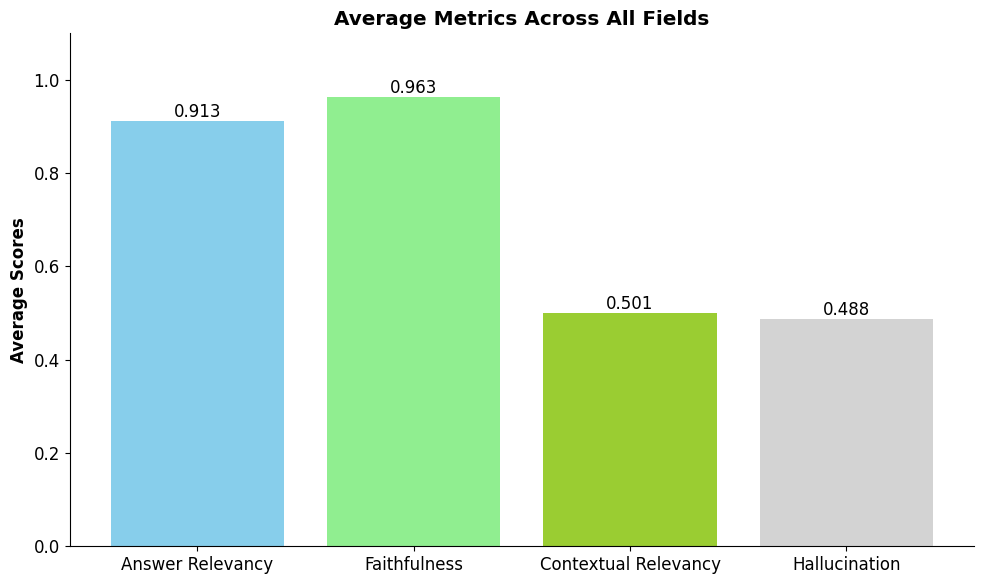

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Increase the default figure size
plt.rcParams['figure.figsize'] = [10, 6]

# Increase the font size for better readability
plt.rcParams['font.size'] = 12

# Calculate averages across all fields
avg_answer_relevancy = np.mean([np.mean(answer_relevancy_metrics[field]) for field in evaluation.keys()])
avg_faithfulness = np.mean([np.mean(faithfulness_metrics[field]) for field in evaluation.keys()])
avg_contextual_relevancy = np.mean([np.mean(contextual_relevancy_metrics[field]) for field in evaluation.keys()])
avg_hallucination = np.mean([np.mean(hallucination_metrics[field]) for field in evaluation.keys()])

# Prepare data for plotting
labels = ['Answer Relevancy', 'Faithfulness', 'Contextual Relevancy', 'Hallucination']
averages = [avg_answer_relevancy, avg_faithfulness, avg_contextual_relevancy, avg_hallucination]
colors = ['skyblue', 'lightgreen', 'yellowgreen', 'lightgrey']

# Create the bar chart
fig, ax = plt.subplots()
bars = ax.bar(labels, averages, color=colors)

ax.set_ylabel('Average Scores', fontweight='bold')
ax.set_title('Average Metrics Across All Fields', fontweight='bold')
ax.set_ylim(0, 1.1)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom')

# Adjust layout and display
plt.tight_layout()
plt.show()


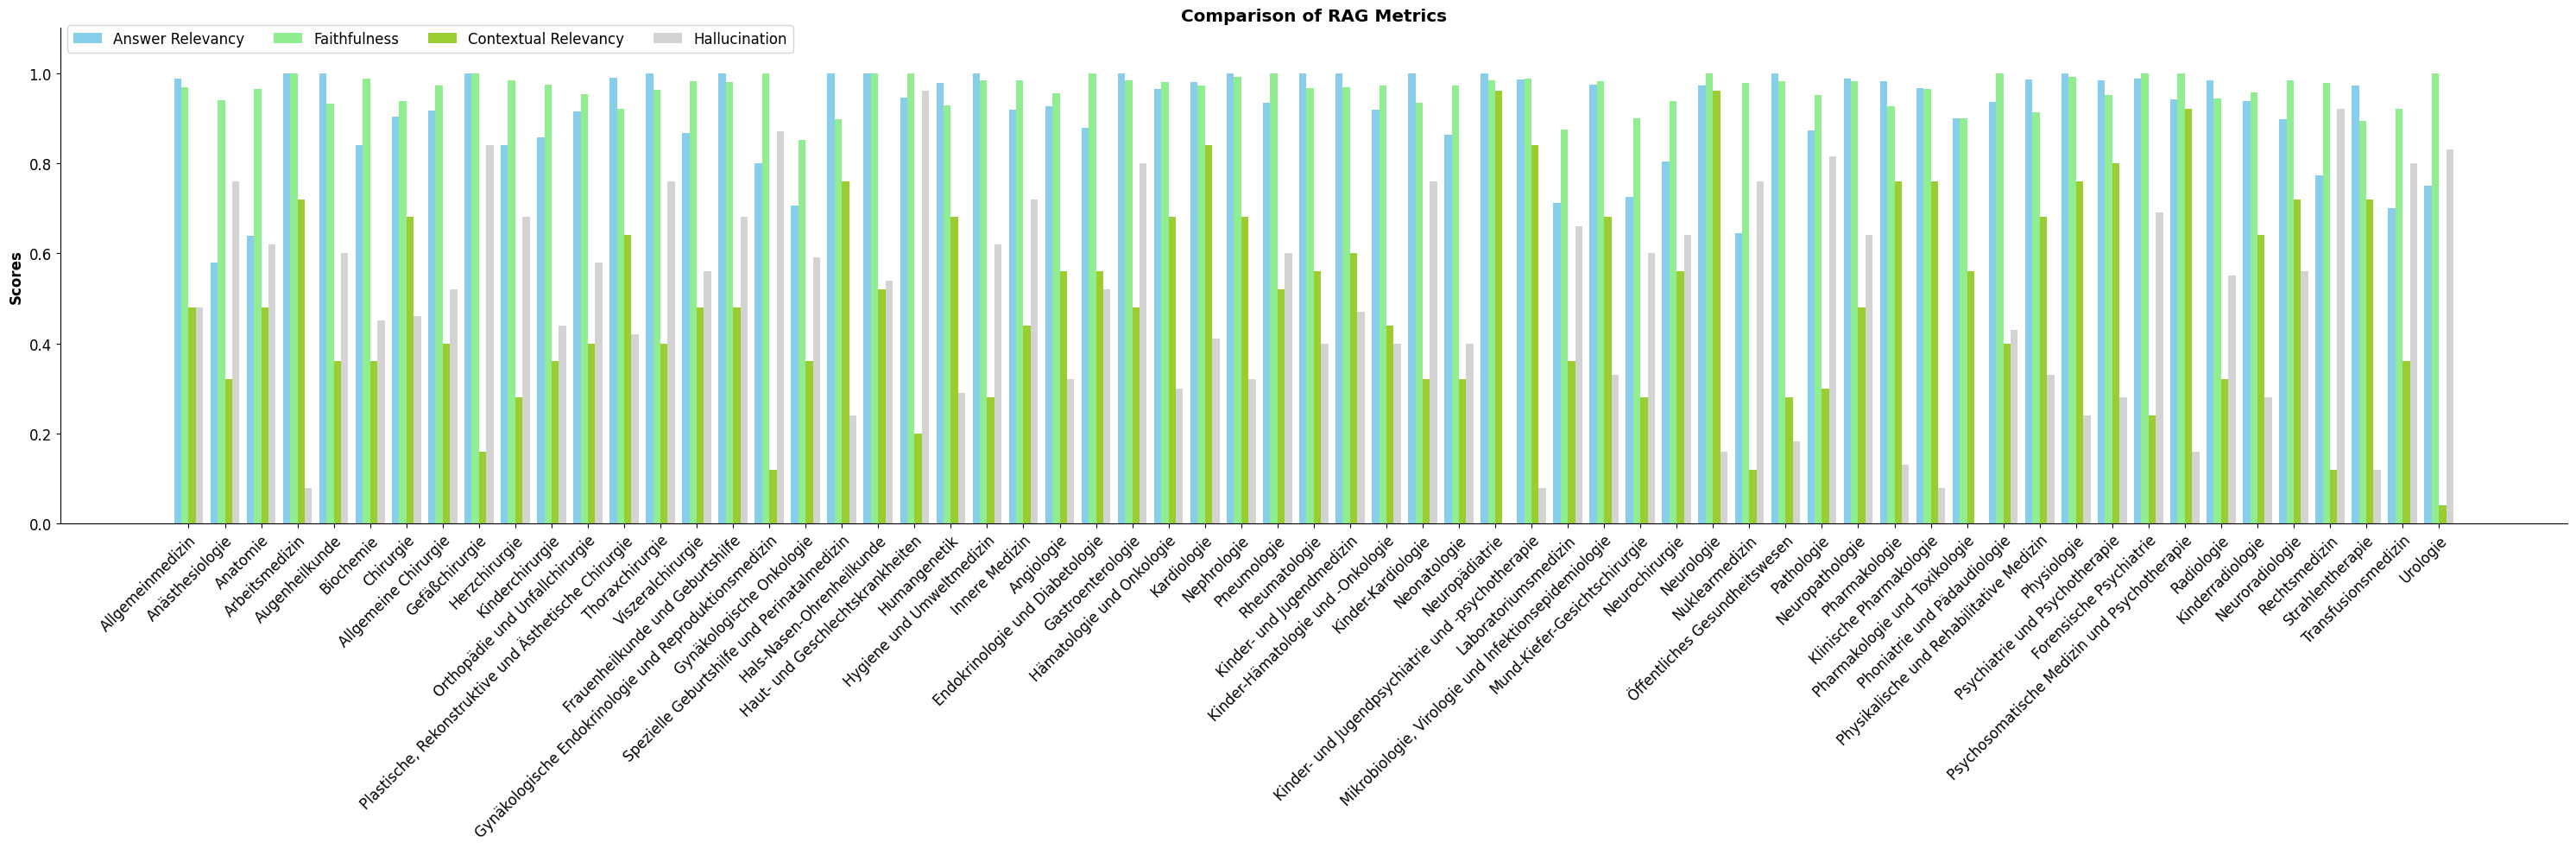

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Increase the default figure size
plt.rcParams['figure.figsize'] = [30, 10]

# Increase the font size for better readability
plt.rcParams['font.size'] = 12

labels = list(evaluation.keys())
answer_relevancy_metrics_means = [np.mean(answer_relevancy_metrics[field]) for field in labels]
faithfulness_metrics_means = [np.mean(faithfulness_metrics[field]) for field in labels]
contextual_relevancy_metrics_means = [np.mean(contextual_relevancy_metrics[field]) for field in labels]
hallucination_metrics_means = [np.mean(hallucination_metrics[field]) for field in labels]

x = np.arange(len(labels))
width = 0.2  # Reduced width to allow for gaps
gap = 0.05  # Small gap between groups

fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, answer_relevancy_metrics_means, width, label='Answer Relevancy', color='skyblue')
rects2 = ax.bar(x - 0.5*width, faithfulness_metrics_means, width, label='Faithfulness', color='lightgreen')
rects3 = ax.bar(x + 0.5*width, contextual_relevancy_metrics_means, width, label='Contextual Relevancy', color='yellowgreen')
rects4 = ax.bar(x + 1.5*width, hallucination_metrics_means, width, label='Hallucination', color='lightgrey')

ax.set_ylabel('Scores', fontweight='bold')
ax.set_title('Comparison of RAG Metrics', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.02), ncol=4)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-axis limits
ax.set_ylim(0, 1.1)

# Add a bit more padding at the bottom for labels and at the top for the legend
plt.subplots_adjust(bottom=0.2, top=0.9)

# Adjust layout and display
fig.tight_layout()
plt.show()

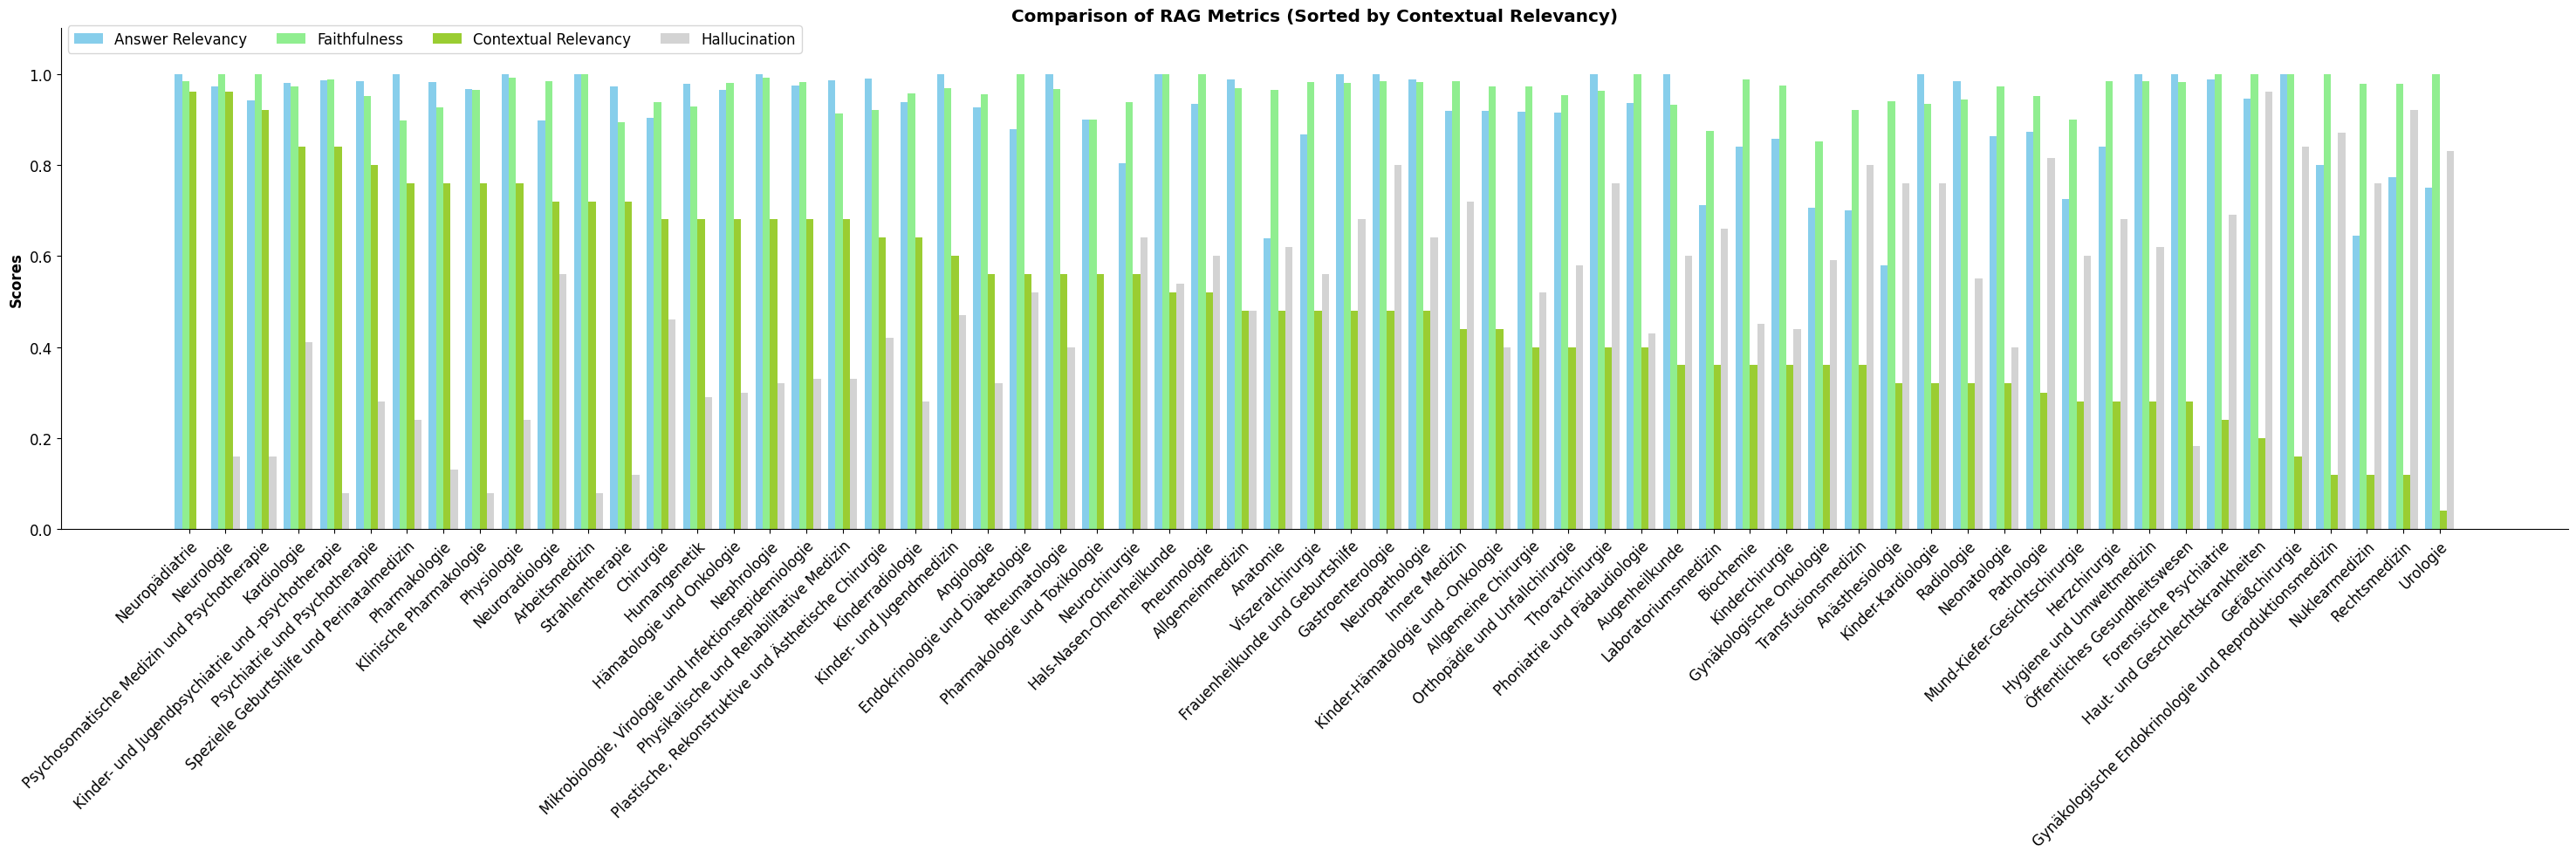

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Increase the default figure size
plt.rcParams['figure.figsize'] = [30, 10]

# Increase the font size for better readability
plt.rcParams['font.size'] = 12

labels = list(evaluation.keys())
answer_relevancy_metrics_means = [np.mean(answer_relevancy_metrics[field]) for field in labels]
faithfulness_metrics_means = [np.mean(faithfulness_metrics[field]) for field in labels]
contextual_relevancy_metrics_means = [np.mean(contextual_relevancy_metrics[field]) for field in labels]
hallucination_metrics_means = [np.mean(hallucination_metrics[field]) for field in labels]

# Sort all lists based on contextual relevancy scores
sorted_indices = sorted(range(len(contextual_relevancy_metrics_means)),
                        key=lambda k: contextual_relevancy_metrics_means[k],
                        reverse=True)

labels = [labels[i] for i in sorted_indices]
answer_relevancy_metrics_means = [answer_relevancy_metrics_means[i] for i in sorted_indices]
faithfulness_metrics_means = [faithfulness_metrics_means[i] for i in sorted_indices]
contextual_relevancy_metrics_means = [contextual_relevancy_metrics_means[i] for i in sorted_indices]
hallucination_metrics_means = [hallucination_metrics_means[i] for i in sorted_indices]

x = np.arange(len(labels))
width = 0.2  # Reduced width to allow for gaps

fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, answer_relevancy_metrics_means, width, label='Answer Relevancy', color='skyblue')
rects2 = ax.bar(x - 0.5*width, faithfulness_metrics_means, width, label='Faithfulness', color='lightgreen')
rects3 = ax.bar(x + 0.5*width, contextual_relevancy_metrics_means, width, label='Contextual Relevancy', color='yellowgreen')
rects4 = ax.bar(x + 1.5*width, hallucination_metrics_means, width, label='Hallucination', color='lightgrey')

ax.set_ylabel('Scores', fontweight='bold')
ax.set_title('Comparison of RAG Metrics (Sorted by Contextual Relevancy)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.02), ncol=4)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-axis limits
ax.set_ylim(0, 1.1)

# Add a bit more padding at the bottom for labels and at the top for the legend
plt.subplots_adjust(bottom=0.2, top=0.9)

# Adjust layout and display
fig.tight_layout()
plt.show()

Observations:
- wide spread of contextual relevancy, probably because of differences in field frequency in dataset
- always quite good relevancy and faithfulness => relevant for answer and does not contradict context
- hallucination increases with lack of contextual relevancy but general relevancy reamins high => llm answers question based on internal knowledge and not provided context

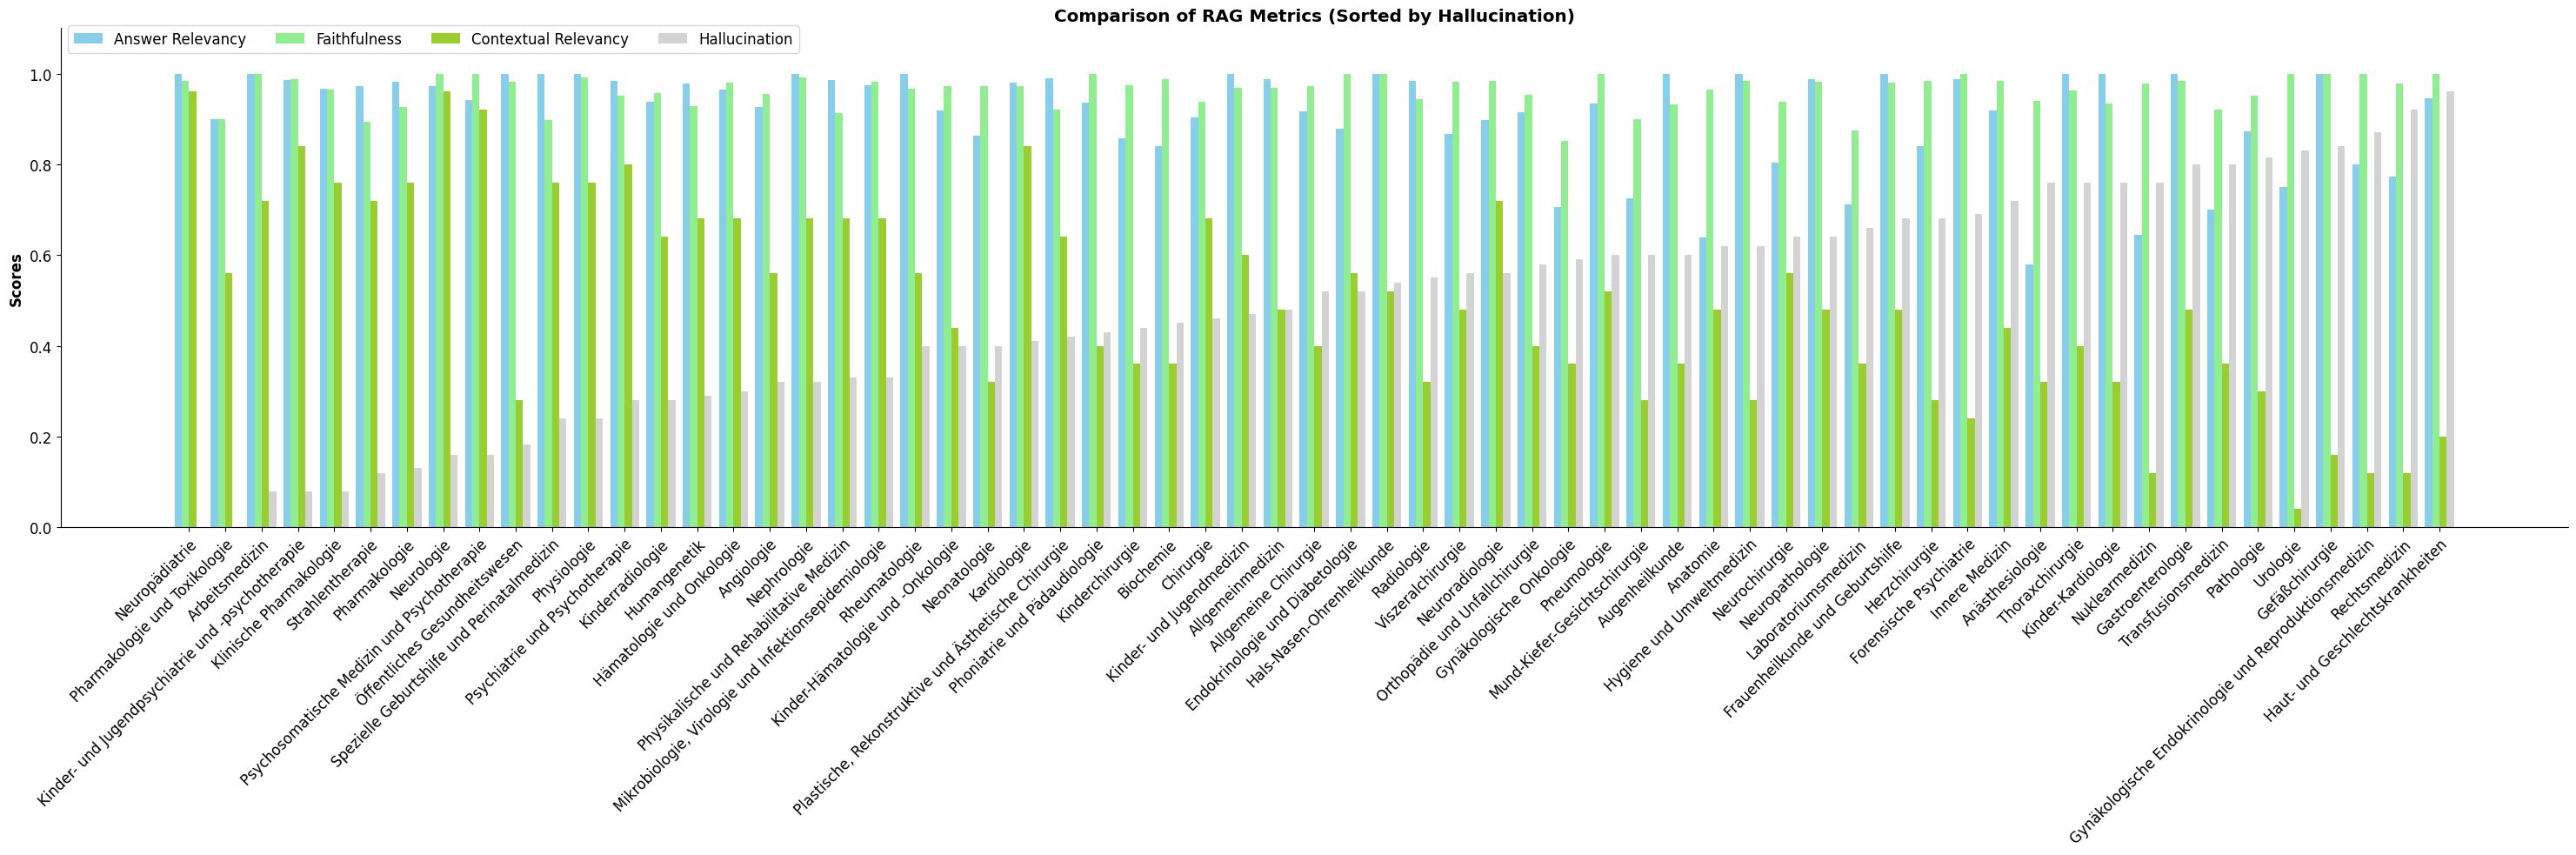

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Increase the default figure size
plt.rcParams['figure.figsize'] = [30, 10]

# Increase the font size for better readability
plt.rcParams['font.size'] = 12

labels = list(evaluation.keys())
answer_relevancy_metrics_means = [np.mean(answer_relevancy_metrics[field]) for field in labels]
faithfulness_metrics_means = [np.mean(faithfulness_metrics[field]) for field in labels]
contextual_relevancy_metrics_means = [np.mean(contextual_relevancy_metrics[field]) for field in labels]
hallucination_metrics_means = [np.mean(hallucination_metrics[field]) for field in labels]

# Sort all lists based on hallucination scores
sorted_indices = sorted(range(len(hallucination_metrics_means)),
                        key=lambda k: hallucination_metrics_means[k],
                        reverse=False)

labels = [labels[i] for i in sorted_indices]
answer_relevancy_metrics_means = [answer_relevancy_metrics_means[i] for i in sorted_indices]
faithfulness_metrics_means = [faithfulness_metrics_means[i] for i in sorted_indices]
contextual_relevancy_metrics_means = [contextual_relevancy_metrics_means[i] for i in sorted_indices]
hallucination_metrics_means = [hallucination_metrics_means[i] for i in sorted_indices]

x = np.arange(len(labels))
width = 0.2  # Reduced width to allow for gaps

fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, answer_relevancy_metrics_means, width, label='Answer Relevancy', color='skyblue')
rects2 = ax.bar(x - 0.5*width, faithfulness_metrics_means, width, label='Faithfulness', color='lightgreen')
rects3 = ax.bar(x + 0.5*width, contextual_relevancy_metrics_means, width, label='Contextual Relevancy', color='yellowgreen')
rects4 = ax.bar(x + 1.5*width, hallucination_metrics_means, width, label='Hallucination', color='lightgrey')

ax.set_ylabel('Scores', fontweight='bold')
ax.set_title('Comparison of RAG Metrics (Sorted by Hallucination)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.02), ncol=4)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-axis limits
ax.set_ylim(0, 1.1)

# Add a bit more padding at the bottom for labels and at the top for the legend
plt.subplots_adjust(bottom=0.2, top=0.9)

# Adjust layout and display
fig.tight_layout()
plt.show()

TODO: generate question and answer pairs from dataset to check if RAG can answer correctly in cases where the data is available
https://docs.llamaindex.ai/en/stable/module_guides/evaluating/evaluating_with_llamadatasets/

# Evaluation Comments

In [ ]:
# Generates questions for each medical field

# from collections import defaultdict
#
# llm_questions = OpenAI(
#     model="gpt-4o-mini",
#     api_key=OPENAI_API_KEY,
#     temperature=1
# )
#
# field_questions_comments = defaultdict(list)
#
# num_questions = 5
# for field in medical_fields:
#     for _ in range(num_questions):
#         question = llm_questions.complete(
#             f"Generiere eine medizinische Frage eines Laien, nach Erfahrungsberichten von Patienten in {field}.\n Antworte ausschließlich mit der Frage!"
#         ).text
#         field_questions_comments[field].append(question)
#         print(question)
#
# with open("medfluencer/evaluation/questions_per_field_comments.json", "w") as file:
#     json.dump(field_questions_comments, file)
#

Warum habe ich ständig Kopfschmerzen, obwohl ich genug Wasser trinke und regelmäßig schlafe?
Wie kann ich sicherstellen, dass ich die richtige Dosis meiner verschriebenen Medikamente einnehme?
Welche Erfahrungen haben andere Patienten gemacht, als sie wegen anhaltender Müdigkeit und Erschöpfung einen Allgemeinarzt aufgesucht haben?
Warum habe ich das Gefühl, dass meine Beschwerden nicht ernst genommen werden, obwohl ich mehrere Arztbesuche hinter mir habe?
Warum habe ich ständig Kopfschmerzen, und wann sollte ich mir Sorgen machen?
Wie sicher ist die Vollnarkose bei Routineoperationen und gibt es Erfahrungen, die das Risiko von Komplikationen während oder nach dem Eingriff betreffen?
Wie erlebt man die Narkose im Operationssaal und gibt es Risiken oder unangenehme Erfahrungen, die Patienten berichten?
Wie sicher ist die Anästhesie während einer Operation und welche Risiken sollten Patienten dabei beachten?
Welche Erfahrungen haben Menschen gemacht, die sich einer Narkose unterziehen mu

Beobachtungen:
- können anhand der Kommentare Statistische Erhebungen durchgeführt werden? => sehr große Anzahl an kommentaren retrieven und durch rag auswerten?

In [ ]:
with open("medfluencer/evaluation/questions_per_field_comments.json", "r") as file:
    field_questions_comments = json.load(file)

In [ ]:
# answers_per_field = defaultdict(list)
# for field, questions in field_questions_comments.items():
#    for question in questions:
#        res = query_engine_comments.query(question)
#        answer = res.response
#        context = [node.text for node in res.source_nodes]
#        answers_per_field[field].append((answer, context))
#        print(answer)
#
# with open("medfluencer/evaluation/answers_per_field_comments.json", "w") as file:
#     json.dump(answers_per_field, file)

Es gibt mehrere mögliche Gründe für Ihre anhaltenden Kopfschmerzen, auch wenn Sie ausreichend Wasser trinken und regelmäßig schlafen:

1. Krankheit: Wenn Sie momentan krank sind, können Kopfschmerzen ein Symptom dieser Erkrankung sein.

2. Ernährung: Eine unausgewogene Ernährung oder zu wenig Nahrungsaufnahme aufgrund von Übelkeit kann Kopfschmerzen verursachen.

3. Koffein: Falls Sie Koffein konsumieren, kann dies zur Dehydrierung beitragen und Kopfschmerzen verstärken.

4. Stress oder Anspannung: Emotionale oder körperliche Belastungen können Kopfschmerzen auslösen.

5. Körperhaltung: Wenn Sie längere Zeit liegen müssen, kann eine ungünstige Körperhaltung zu Verspannungen und Kopfschmerzen führen.

6. Überhydrierung: Zu viel Flüssigkeitsaufnahme kann ebenfalls Probleme verursachen.

7. Schlafqualität: Obwohl Sie regelmäßig schlafen, könnte die Qualität Ihres Schlafes beeinträchtigt sein.

Es wäre ratsam, einen Arzt aufzusuchen, um die genaue Ursache Ihrer Kopfschmerzen zu ermitteln u

FileNotFoundError: [Errno 2] No such file or directory: 'evaluation/answers_per_field_comments.json'

In [ ]:
with open("medfluencer/evaluation/answers_per_field_comments.json", "r") as file:
    answers_per_field = json.load(file)

In [ ]:
from deepeval import evaluate
from deepeval.metrics import (
    AnswerRelevancyMetric,
    FaithfulnessMetric,
    ContextualRelevancyMetric,
    HallucinationMetric,
)
from deepeval.test_case import LLMTestCase

/usr/local/lib/python3.10/dist-packages/deepeval/__init__.py:45: UserWarning: You are using deepeval version 0.21.68, however version 0.21.71 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


In [ ]:
test_cases_per_field = defaultdict(list)

for field, questions in field_questions_comments.items():
    for idx, question in enumerate(questions):
        actual_output, retrieval_context = answers_per_field[field][idx]
        test_case = LLMTestCase(
            input=question,
            actual_output=actual_output,
            retrieval_context=retrieval_context,
            context=retrieval_context,
        )

        test_cases_per_field[field].append(test_case)

In [ ]:
len(list(test_cases_per_field.keys())) * 10 * 4

2520

In [ ]:
from deepeval.models.base_model import DeepEvalBaseLLM

class Claude(DeepEvalBaseLLM):
    def __init__(
        self
    ):
        self.model = Anthropic(
            model="claude-3-5-sonnet-20240620",
            api_key=ANTHROPIC_API_KEY,
            max_tokens=4096,
        )

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        model = self.load_model()

        res = model.complete(prompt)
        return res.text

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "claude-3-5-sonnet-20240620"


class GPT4mini(DeepEvalBaseLLM):
    def __init__(
        self
    ):
        self.model = OpenAI(temperature=0, model="gpt-4o-mini", api_key=OPENAI_API_KEY)


    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        model = self.load_model()

        res = model.complete(prompt)
        return res.text

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "gpt-4o-mini"

In [ ]:
# import pickle
#
# model = GPT4mini()
#
# answer_relevancy_metric = AnswerRelevancyMetric(
#     threshold=0.6,
#     model=model,
#     include_reason=False
# )
#
# faithfulness_metric = FaithfulnessMetric(
#     threshold=0.6,
#     model=model,
#     include_reason=False
# )
#
# contextual_relevancy_metric = ContextualRelevancyMetric(
#     threshold=0.6,
#     model=model,
#     include_reason=False
# )
#
# hallucination_metric = HallucinationMetric(
#     threshold=0.5,
#     model=model,
#     include_reason=False
# )
#
# evaluations = {}
#
# for field, test_case in test_cases_per_field.items():
#     if field in evaluations: continue
#     evaluation = evaluate(
#         test_case,
#         [
#             answer_relevancy_metric,
#             faithfulness_metric,
#             contextual_relevancy_metric,
#             hallucination_metric,
#         ],
#     )
#
#     evaluations[field] = evaluation
#
# with open("medfluencer/evaluation/evaluation_metrics_rag_comments.pkl", "wb") as file:
#     pickle.dump(evaluations, file)

Observation:
- RAG system retrieves comments which state the same question but not the corresponding answer => generate question answer pairs of comments beforehand?

In [ ]:
import pickle
with open("medfluencer/evaluation/evaluation_metrics_rag_comments.pkl", "rb") as file:
    evaluation = pickle.load(file)

In [ ]:
answer_relevancy_metrics = defaultdict(list)
faithfulness_metrics = defaultdict(list)
contextual_relevancy_metrics = defaultdict(list)
hallucination_metrics = defaultdict(list)

for field, test_cases in evaluation.items():
    for test_case in [test_case.metrics_metadata for test_case in test_cases]:
        for metric in test_case:
            if metric.metric == "Answer Relevancy":
                answer_relevancy_metrics[field].append(metric.score)
            elif metric.metric == "Faithfulness":
                faithfulness_metrics[field].append(metric.score)
            elif metric.metric == "Contextual Relevancy":
                contextual_relevancy_metrics[field].append(metric.score)
            elif metric.metric == "Hallucination":
                hallucination_metrics[field].append(metric.score)


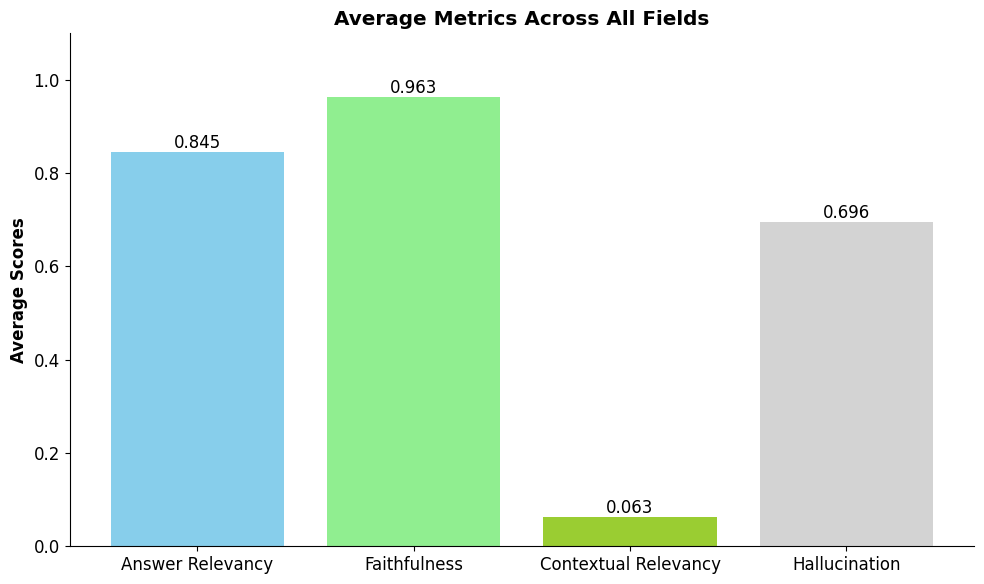

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Increase the default figure size
plt.rcParams['figure.figsize'] = [10, 6]

# Increase the font size for better readability
plt.rcParams['font.size'] = 12

# Calculate averages across all fields
avg_answer_relevancy = np.mean([np.mean(answer_relevancy_metrics[field]) for field in evaluation.keys()])
avg_faithfulness = np.mean([np.mean(faithfulness_metrics[field]) for field in evaluation.keys()])
avg_contextual_relevancy = np.mean([np.mean(contextual_relevancy_metrics[field]) for field in evaluation.keys()])
avg_hallucination = np.mean([np.mean(hallucination_metrics[field]) for field in evaluation.keys()])

# Prepare data for plotting
labels = ['Answer Relevancy', 'Faithfulness', 'Contextual Relevancy', 'Hallucination']
averages = [avg_answer_relevancy, avg_faithfulness, avg_contextual_relevancy, avg_hallucination]
colors = ['skyblue', 'lightgreen', 'yellowgreen', 'lightgrey']

# Create the bar chart
fig, ax = plt.subplots()
bars = ax.bar(labels, averages, color=colors)

ax.set_ylabel('Average Scores', fontweight='bold')
ax.set_title('Average Metrics Across All Fields', fontweight='bold')
ax.set_ylim(0, 1.1)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom')

# Adjust layout and display
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Increase the default figure size
plt.rcParams['figure.figsize'] = [30, 10]

# Increase the font size for better readability
plt.rcParams['font.size'] = 12

labels = list(evaluation.keys())
answer_relevancy_metrics_means = [np.mean(answer_relevancy_metrics[field]) for field in labels]
faithfulness_metrics_means = [np.mean(faithfulness_metrics[field]) for field in labels]
contextual_relevancy_metrics_means = [np.mean(contextual_relevancy_metrics[field]) for field in labels]
hallucination_metrics_means = [np.mean(hallucination_metrics[field]) for field in labels]

# Sort all lists based on contextual relevancy scores
sorted_indices = sorted(range(len(contextual_relevancy_metrics_means)),
                        key=lambda k: contextual_relevancy_metrics_means[k],
                        reverse=True)

labels = [labels[i] for i in sorted_indices]
answer_relevancy_metrics_means = [answer_relevancy_metrics_means[i] for i in sorted_indices]
faithfulness_metrics_means = [faithfulness_metrics_means[i] for i in sorted_indices]
contextual_relevancy_metrics_means = [contextual_relevancy_metrics_means[i] for i in sorted_indices]
hallucination_metrics_means = [hallucination_metrics_means[i] for i in sorted_indices]

x = np.arange(len(labels))
width = 0.2  # Reduced width to allow for gaps

fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, answer_relevancy_metrics_means, width, label='Answer Relevancy', color='skyblue')
rects2 = ax.bar(x - 0.5*width, faithfulness_metrics_means, width, label='Faithfulness', color='lightgreen')
rects3 = ax.bar(x + 0.5*width, contextual_relevancy_metrics_means, width, label='Contextual Relevancy', color='yellowgreen')
rects4 = ax.bar(x + 1.5*width, hallucination_metrics_means, width, label='Hallucination', color='lightgrey')

ax.set_ylabel('Scores', fontweight='bold')
ax.set_title('Comparison of RAG Metrics (Sorted by Contextual Relevancy)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.02), ncol=4)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-axis limits
ax.set_ylim(0, 1.1)

# Add a bit more padding at the bottom for labels and at the top for the legend
plt.subplots_adjust(bottom=0.2, top=0.9)

# Adjust layout and display
fig.tight_layout()
plt.show()

# Evaluation Comments Extended

In [3]:
with open("medfluencer/evaluation/questions_per_field_comments.json", "r") as file:
    field_questions_comments = json.load(file)

In [4]:
from collections import defaultdict

In [ ]:
# answers_per_field = defaultdict(list)
# for field, questions in field_questions_comments.items():
#    for question in questions:
#        res = query_engine_comments_extended.query(question)
#        answer = res.response
#        context = [node.text for node in res.source_nodes]
#        answers_per_field[field].append((answer, context))
#        print(answer)
#
# with open("medfluencer/evaluation/answers_per_field_comments_extended.json", "w") as file:
#     json.dump(answers_per_field, file)

Es gibt mehrere mögliche Gründe für anhaltende Kopfschmerzen, auch wenn Sie ausreichend Wasser trinken und regelmäßig schlafen. Einige Faktoren, die in Betracht gezogen werden sollten, sind:

1. Ernährung: Bestimmte Lebensmittel oder Getränke, insbesondere solche mit viel Zucker oder kurzkettigen Kohlenhydraten, können Kopfschmerzen auslösen.

2. Koffeinkonsum: Zu viel oder zu wenig Koffein kann Kopfschmerzen verursachen.

3. Stress und Anspannung: Emotionaler oder körperlicher Stress kann zu Kopfschmerzen führen.

4. Haltung und Ergonomie: Schlechte Körperhaltung, besonders bei der Arbeit am Computer, kann Verspannungen und Kopfschmerzen verursachen.

5. Umweltfaktoren: Lärm, helles Licht oder bestimmte Gerüche können Kopfschmerzen auslösen.

6. Medizinische Gründe: Es könnte auch eine zugrunde liegende medizinische Ursache geben, die von einem Arzt untersucht werden sollte.

Es ist ratsam, ein Tagebuch zu führen, um mögliche Auslöser zu identifizieren, und bei anhaltenden Beschwerden

In [5]:
with open("medfluencer/evaluation/answers_per_field_comments_extended.json", "r") as file:
    answers_per_field = json.load(file)

In [6]:
from deepeval import evaluate
from deepeval.metrics import (
    AnswerRelevancyMetric,
    FaithfulnessMetric,
    ContextualRelevancyMetric,
    HallucinationMetric,
)
from deepeval.test_case import LLMTestCase

In [10]:
field_questions_comments["Pathologie"] = field_questions_comments["Pathologie"][:5] # bug: field occurs two times

In [11]:
test_cases_per_field = defaultdict(list)

for field, questions in field_questions_comments.items():
    for idx, question in enumerate(questions):
        actual_output, retrieval_context = answers_per_field[field][idx]
        test_case = LLMTestCase(
            input=question,
            actual_output=actual_output,
            retrieval_context=retrieval_context,
            context=retrieval_context,
        )

        test_cases_per_field[field].append(test_case)

In [12]:
len(list(test_cases_per_field.keys())) * 10 * 4

2520

In [13]:
from deepeval.models.base_model import DeepEvalBaseLLM

class Claude(DeepEvalBaseLLM):
    def __init__(
        self
    ):
        self.model = Anthropic(
            model="claude-3-5-sonnet-20240620",
            api_key=ANTHROPIC_API_KEY,
            max_tokens=4096,
        )

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        model = self.load_model()

        res = model.complete(prompt)
        return res.text

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "claude-3-5-sonnet-20240620"


class GPT4mini(DeepEvalBaseLLM):
    def __init__(
        self
    ):
        self.model = OpenAI(temperature=0, model="gpt-4o-mini", api_key=OPENAI_API_KEY)


    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        model = self.load_model()

        res = model.complete(prompt)
        return res.text

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "gpt-4o-mini"

In [15]:
import pickle
model = GPT4mini()
answer_relevancy_metric = AnswerRelevancyMetric(
    threshold=0.6,
    model=model,
    include_reason=False
)
faithfulness_metric = FaithfulnessMetric(
    threshold=0.6,
    model=model,
    include_reason=False
)
contextual_relevancy_metric = ContextualRelevancyMetric(
    threshold=0.6,
    model=model,
    include_reason=False
)
hallucination_metric = HallucinationMetric(
    threshold=0.5,
    model=model,
    include_reason=False
)
#evaluations = {}
for field, test_case in test_cases_per_field.items():
    if field in evaluations: continue
    evaluation = evaluate(
        test_case,
        [
            answer_relevancy_metric,
            faithfulness_metric,
            contextual_relevancy_metric,
            hallucination_metric,
        ],
    )
    evaluations[field] = evaluation
    with open("medfluencer/evaluation/evaluation_metrics_rag_comments_extended.pkl", "wb") as file:
        pickle.dump(evaluations, file)

Output()

Allgemeinmedizin
Anästhesiologie
Anatomie
Arbeitsmedizin
Augenheilkunde
Biochemie
Chirurgie
Allgemeine Chirurgie
Gefäßchirurgie
Herzchirurgie
Kinderchirurgie
Orthopädie und Unfallchirurgie
Plastische, Rekonstruktive und Ästhetische Chirurgie
Thoraxchirurgie
Viszeralchirurgie
Frauenheilkunde und Geburtshilfe
Gynäkologische Endokrinologie und Reproduktionsmedizin
Gynäkologische Onkologie
Spezielle Geburtshilfe und Perinatalmedizin
Hals-Nasen-Ohrenheilkunde
Haut- und Geschlechtskrankheiten
Humangenetik
Hygiene und Umweltmedizin
Innere Medizin
Angiologie
Endokrinologie und Diabetologie
Gastroenterologie
Hämatologie und Onkologie
Kardiologie
Nephrologie
Pneumologie
Rheumatologie
Kinder- und Jugendmedizin
Kinder-Hämatologie und -Onkologie
Kinder-Kardiologie
Neonatologie
Neuropädiatrie
Kinder- und Jugendpsychiatrie und -psychotherapie
Laboratoriumsmedizin
Mikrobiologie, Virologie und Infektionsepidemiologie
Mund-Kiefer-Gesichtschirurgie
Neurochirurgie
Neurologie
Nuklearmedizin
Öffentliches Ge

Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Hallucination (score: 1.0, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Was sind die häufigsten Erfahrungen von Patienten, die mit pathologischen Befunden konfrontiert wurden, und wie haben diese ihre Sicht auf ihre Krankheit beeinflusst?
  - actual output: Es gibt keine allgemeingültige Antwort auf diese Frage, da die Erfahrungen von Patienten mit pathologischen Befunden sehr individuell sind. Häufig erleben Patienten jedoch eine Reihe von Emotionen wie Schock, Angst, Trauer oder Wut. Die Konfrontation mit einer schwerwie

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Neuropathologie
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 0.6875, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 0.9565217391304348, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Hallucination (score: 0.0, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Was sind die häufigsten neurologischen Symptome, die bei Patienten mit Erkrankungen des Nervensystems auftreten, und wie unterscheiden sich diese in den verschiedenen Krankheitsbildern?
  - actual output: Neurologische Symptome können je nach Erkrankung sehr vielfältig sein. Häufig auftretende Symptome umfassen:

1. Gleichgewichtsstörungen
2. Sehstörungen oder Probleme mit den Augen
3. Gesichtssymptome
4. Bluthochdruck
5. Kopfschmerze

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Pharmakologie
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 0.9333333333333333, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Hallucination (score: 0.6, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Welche möglichen Nebenwirkungen können bei der Einnahme von Schmerzmitteln auftreten, und gibt es Erfahrungsberichte, die darauf hinweisen, wie häufig diese Nebenwirkungen auftreten?
  - actual output: Bei der Einnahme von Schmerzmitteln können verschiedene Nebenwirkungen auftreten. Häufig berichtete Nebenwirkungen umfassen Sodbrennen und Kopfschmerzen, die sich sogar zu Migräne entwickeln können. Insbesondere bei längerfristiger Einnahm

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Klinische Pharmakologie
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Hallucination (score: 0.8, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Welche Nebenwirkungen haben andere Patienten bei der Einnahme von Medikamenten zur Behandlung von Bluthochdruck erlebt?
  - actual output: Es ist schwierig, eine allgemeingültige Antwort zu geben, da die Erfahrungen mit Blutdruckmedikamenten sehr individuell sein können. Einige Patienten berichten von Nebenwirkungen, während andere gut auf die Medikamente ansprechen. In manchen Fällen treten Nebenwirkungen auf, ohne dass der Blutdruck gesenkt wird. 

W

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Pharmakologie und Toxikologie
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 0.875, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Hallucination (score: 0.4, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Welche Nebenwirkungen können bei der Einnahme von Schmerzmitteln auftreten, und wie unterscheiden sich diese je nach Medikament?
  - actual output: Schmerzmittel können verschiedene Nebenwirkungen hervorrufen, die je nach Medikament variieren können:

1. Ibuprofen und ähnliche Schmerzmittel:
- Bei Langzeitanwendung können Kopfschmerzen auftreten
- Können Sodbrennen verursachen
- Mögliche Magenbeschwerden, weshalb bei Dauertherapie oft ein Magenschutz

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Output()

Output()

Output()

Output()



Metrics Summary

  - ❌ Answer Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Hallucination (score: 1.0, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Was sind die häufigsten Symptome und Behandlungsmöglichkeiten bei Sprach- und Stimmstörungen bei Kindern?
  - actual output: Leider enthält der gegebene Kontext keine spezifischen Informationen zu den häufigsten Symptomen und Behandlungsmöglichkeiten von Sprach- und Stimmstörungen bei Kindern. Der Kontext behandelt verschiedene andere medizinische Themen, aber nicht das in der Frage angesprochene Thema. Ohne zusätzliche relevante Informationen kann ich

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Physikalische und Rehabilitative Medizin
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Hallucination (score: 1.0, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Wie effektiv ist die physikalische Therapie bei der Behandlung von chronischen Rückenschmerzen, und gibt es bestimmte Methoden, die besonders empfohlen werden?
  - actual output: Die Effektivität der physikalischen Therapie bei chronischen Rückenschmerzen kann von Person zu Person variieren. Es gibt keine universelle Lösung, da die Ursachen und Ausprägungen von Rückenschmerzen sehr individuell sein können. 

Generell wird empfohlen, einen ganzheitliche

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Physiologie
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 0.8, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Hallucination (score: 0.0, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Wie beeinflusst regelmäßige Bewegung die Funktion des Herz-Kreislauf-Systems bei älteren Menschen?
  - actual output: Regelmäßige Bewegung hat einen positiven Einfluss auf das Herz-Kreislauf-System älterer Menschen. Sie kann die Herzfunktion verbessern und zur Regulierung des Nervensystems beitragen. Wichtig ist dabei, die Übungen an die individuellen Fähigkeiten anzupassen. 

Bei Herzproblemen wie einer Herzinsuffizienz kann eine Kombination aus angep

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Psychiatrie und Psychotherapie
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.2, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Hallucination (score: 1.0, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Wie kann ich herausfinden, ob eine Psychotherapie bei mir tatsächlich helfen könnte, und was sollte ich dabei beachten?
  - actual output: Um herauszufinden, ob eine Psychotherapie für Sie hilfreich sein könnte, gibt es einige Schritte, die Sie in Betracht ziehen sollten:

1. Selbstreflexion: Überlegen Sie, welche Probleme oder Symptome Sie belasten und ob Sie das Gefühl haben, dass professionelle Unterstützung nötig wäre.

2. Ärztliche Beratung: Sprec

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Forensische Psychiatrie
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 0.75, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 0.6666666666666666, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Hallucination (score: 1.0, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Wie wirken sich langanhaltende Aufenthalte in der forensischen Psychiatrie auf das Verhalten und die soziale Reintegration der Patienten aus?
  - actual output: I apologize, but I don't have enough relevant information in the given context to properly answer your question about the effects of long-term stays in forensic psychiatry on patient behavior and social reintegration. The provided context does not contain any specific informatio

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Psychosomatische Medizin und Psychotherapie
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Contextual Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Hallucination (score: 0.8, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Kann Stress wirklich körperliche Symptome verursachen, und wie erkennt man, ob es sich um psychosomatische Beschwerden handelt?
  - actual output: Ja, Stress kann tatsächlich eine Vielzahl von körperlichen Symptomen verursachen. Dies ist ein gut dokumentiertes Phänomen im Bereich der psychosomatischen Erkrankungen. 

Bei anhaltendem Stress können verschiedene Organsysteme beeinträchtigt werden, was zu Beschwerden wie Übelkeit, Durchfall, Bauchschmerzen

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Radiologie
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Hallucination (score: 0.4, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Wie genau sind die Ergebnisse von MRT-Untersuchungen im Vergleich zu anderen bildgebenden Verfahren, wenn es um die Diagnose von Tumoren geht?
  - actual output: MRT-Untersuchungen liefern in der Regel sehr detaillierte Bilder und können bei der Diagnose von Tumoren sehr hilfreich sein. Allerdings ist es wichtig zu verstehen, dass MRT-Ergebnisse allein nicht immer ausreichend für eine endgültige Diagnose sind. 

Die Genauigkeit hängt von verschiedenen 

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Hallucination (score: 1.0, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Wie sicher ist es, dass Röntgenuntersuchungen bei kleinen Kindern keine langfristigen gesundheitlichen Auswirkungen haben?
  - actual output: Es ist wichtig, die Notwendigkeit und mögliche Risiken von Röntgenuntersuchungen bei Kindern sorgfältig abzuwägen. Röntgenaufnahmen werden in der Regel nur durchgeführt, wenn sie medizinisch erforderlich sind und der erwartete Nutzen die potenziellen Risiken überwiegt. 

Moderne Röntgengeräte verwenden sehr gerin

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Neuroradiologie
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Hallucination (score: 1.0, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Welche Erfahrungen haben Patienten mit der Durchführung einer MRT-Untersuchung des Gehirns in Bezug auf das Verfahren und die Ergebnisse gemacht?
  - actual output: Patienten berichten unterschiedliche Erfahrungen mit MRT-Untersuchungen des Gehirns:

Einige empfinden die Untersuchung als relativ angenehm und ruhig im Vergleich zu anderen bildgebenden Verfahren. Die Geräuschkulisse wird als weniger störend wahrgenommen als bei manch anderen Untersuchung

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Rechtsmedizin
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Hallucination (score: 1.0, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Wie zuverlässig sind die Ergebnisse von forensischen DNA-Analysen in der Rechtsmedizin?
  - actual output: DNA-Analysen in der Rechtsmedizin gelten als sehr zuverlässig und präzise. Die Methoden haben sich über die Jahre stark verbessert und verfeinert. Moderne Techniken können selbst aus kleinsten Spuren und stark degradiertem Material noch verwertbare Ergebnisse liefern. 

Allerdings ist es wichtig zu betonen, dass kein Test 100% fehlerfrei ist. Die 

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Strahlentherapie
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Hallucination (score: 1.0, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Wie lange dauern die Nebenwirkungen der Strahlentherapie an und wie stark sind sie im Vergleich zu den erwarteten positiven Effekten?
  - actual output: Die Dauer und Intensität der Nebenwirkungen einer Strahlentherapie können sehr individuell sein. Generell können die Nebenwirkungen mehrere Wochen bis Monate anhalten, in manchen Fällen sogar länger. Kurzfristig kann es zu Hautreizungen, Müdigkeit und lokalen Beschwerden kommen. 

Es ist wichtig zu bea

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.2, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Hallucination (score: 0.4, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Wie sicher ist eine Bluttransfusion und welche Nebenwirkungen können dabei auftreten?
  - actual output: Bluttransfusionen und Plasmaübertragungen können, wie viele medizinische Behandlungen, mit gewissen Risiken verbunden sein. Mögliche Nebenwirkungen können allergische Reaktionen und Unverträglichkeiten umfassen, ähnlich wie bei einer Bluttransfusion. Bei geschwächten Patienten, wie beispielsweise solchen mit Coronavirus-Infektionen, können diese Ris

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Output()

Urologie
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

Output()

Output()

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 0.7857142857142857, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ✅ Faithfulness (score: 0.9285714285714286, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)
  - ❌ Hallucination (score: 0.8, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Was sind typische Symptome, die auf eine Harnwegsinfektion hinweisen könnten, und wie lange dauert es in der Regel, bis man eine Besserung nach der Behandlung verspürt?
  - actual output: Typische Symptome einer Harnwegsinfektion können Schmerzen oder ein dumpfes Gefühl in der Nierengegend sein, die sich auch in den vorderen Unterbauch ausstrahlen können. Einige Betroffene berichten von Schmerzen, die sie in der Flanke spü

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

In [16]:
import pickle
with open("medfluencer/evaluation/evaluation_metrics_rag_comments_extended.pkl", "rb") as file:
    evaluation = pickle.load(file)

In [17]:
answer_relevancy_metrics = defaultdict(list)
faithfulness_metrics = defaultdict(list)
contextual_relevancy_metrics = defaultdict(list)
hallucination_metrics = defaultdict(list)

for field, test_cases in evaluation.items():
    for test_case in [test_case.metrics_metadata for test_case in test_cases]:
        for metric in test_case:
            if metric.metric == "Answer Relevancy":
                answer_relevancy_metrics[field].append(metric.score)
            elif metric.metric == "Faithfulness":
                faithfulness_metrics[field].append(metric.score)
            elif metric.metric == "Contextual Relevancy":
                contextual_relevancy_metrics[field].append(metric.score)
            elif metric.metric == "Hallucination":
                hallucination_metrics[field].append(metric.score)


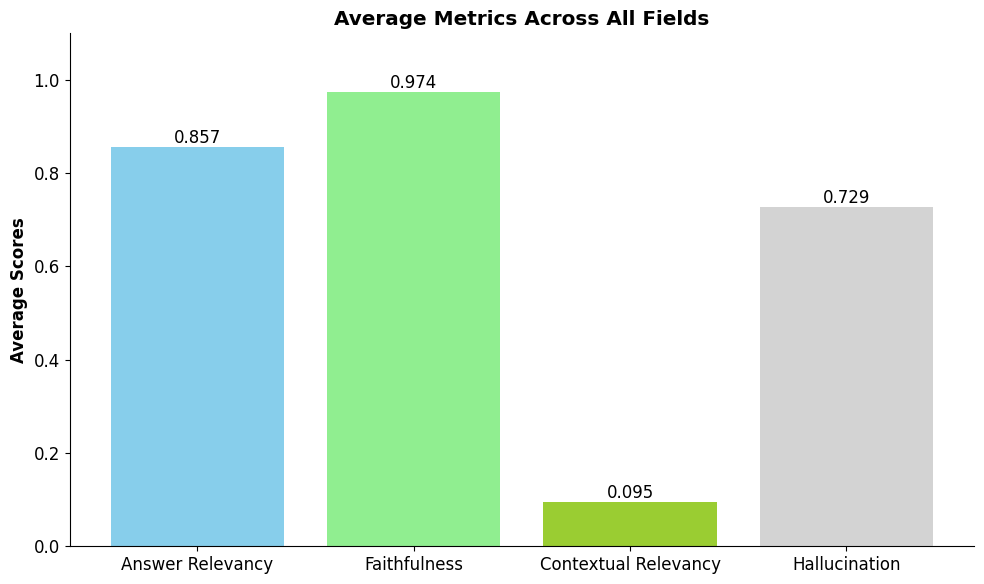

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Increase the default figure size
plt.rcParams['figure.figsize'] = [10, 6]

# Increase the font size for better readability
plt.rcParams['font.size'] = 12

# Calculate averages across all fields
avg_answer_relevancy = np.mean([np.mean(answer_relevancy_metrics[field]) for field in evaluation.keys()])
avg_faithfulness = np.mean([np.mean(faithfulness_metrics[field]) for field in evaluation.keys()])
avg_contextual_relevancy = np.mean([np.mean(contextual_relevancy_metrics[field]) for field in evaluation.keys()])
avg_hallucination = np.mean([np.mean(hallucination_metrics[field]) for field in evaluation.keys()])

# Prepare data for plotting
labels = ['Answer Relevancy', 'Faithfulness', 'Contextual Relevancy', 'Hallucination']
averages = [avg_answer_relevancy, avg_faithfulness, avg_contextual_relevancy, avg_hallucination]
colors = ['skyblue', 'lightgreen', 'yellowgreen', 'lightgrey']

# Create the bar chart
fig, ax = plt.subplots()
bars = ax.bar(labels, averages, color=colors)

ax.set_ylabel('Average Scores', fontweight='bold')
ax.set_title('Average Metrics Across All Fields', fontweight='bold')
ax.set_ylim(0, 1.1)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom')

# Adjust layout and display
plt.tight_layout()
plt.show()


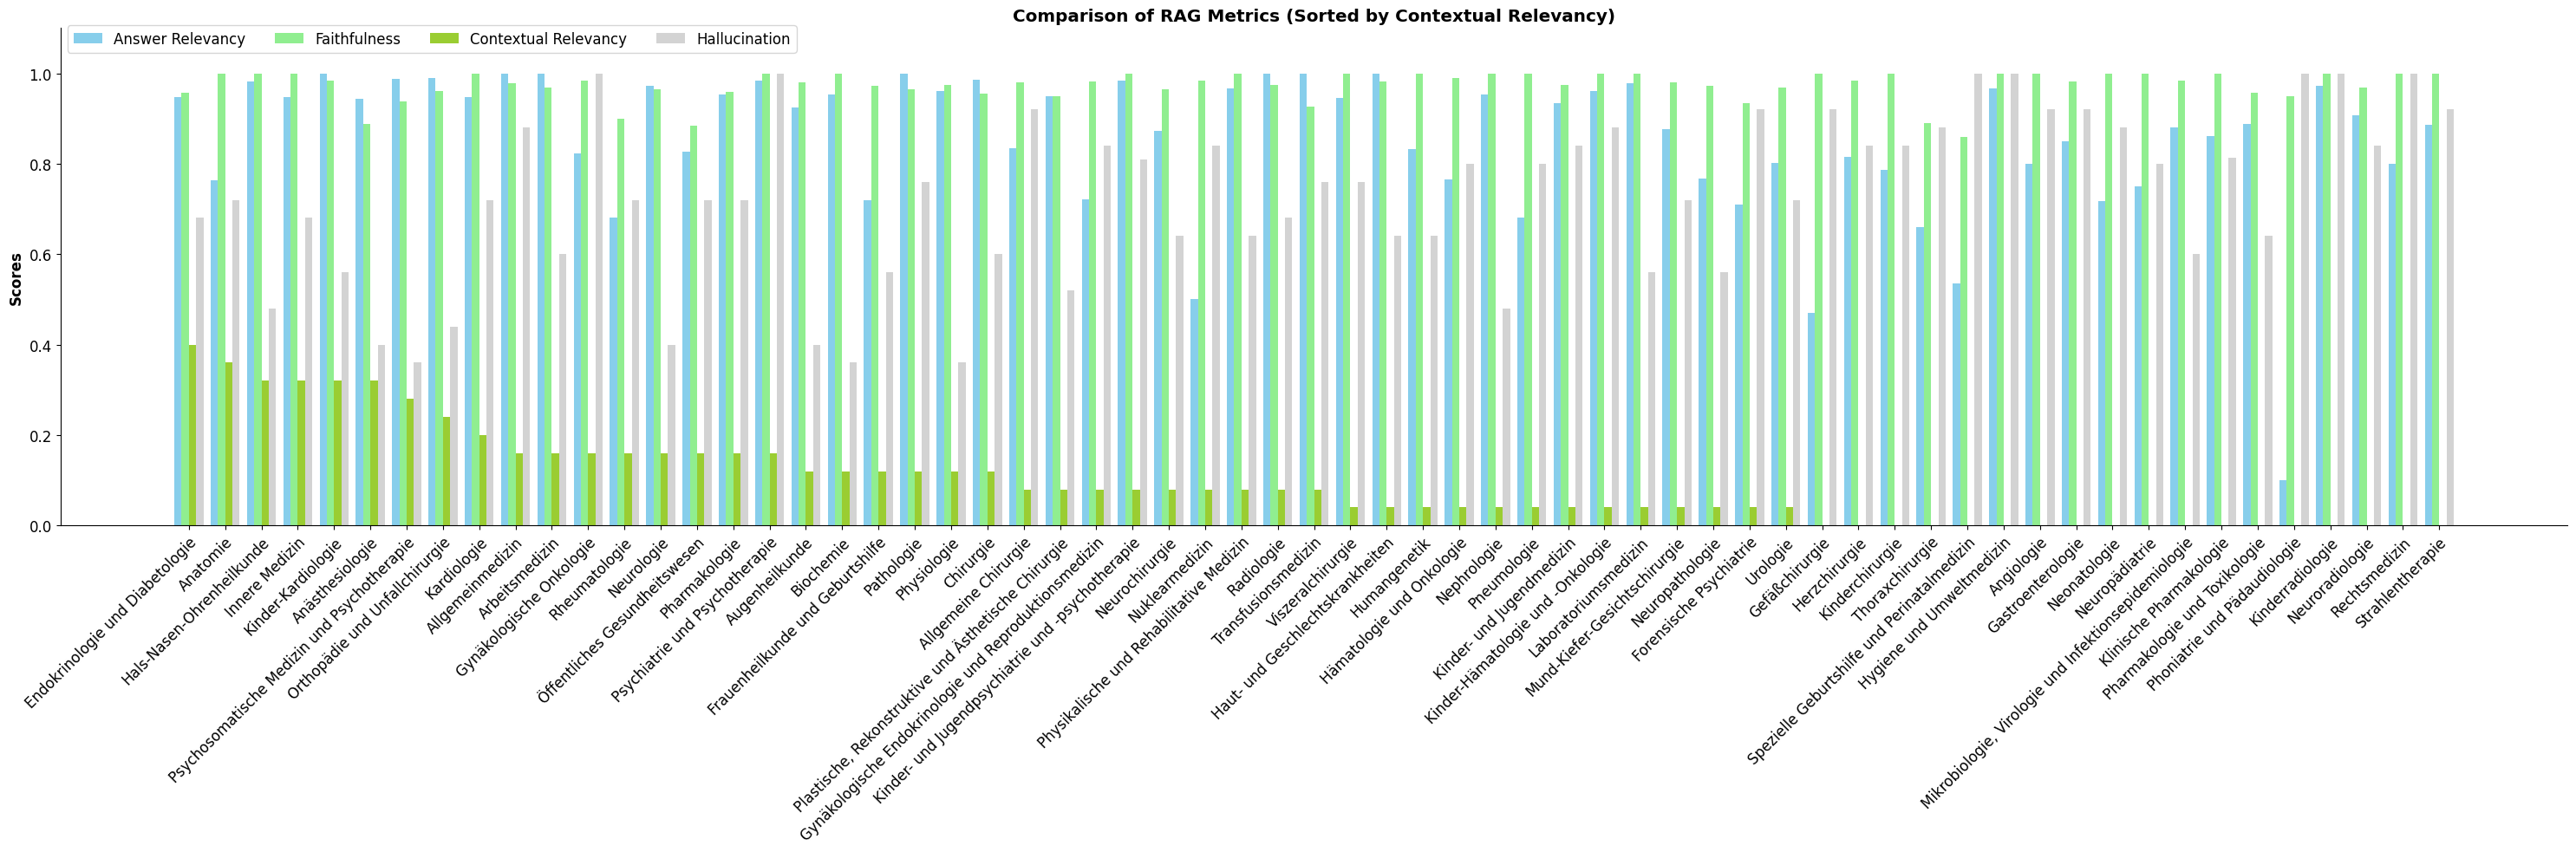

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Increase the default figure size
plt.rcParams['figure.figsize'] = [30, 10]

# Increase the font size for better readability
plt.rcParams['font.size'] = 12

labels = list(evaluation.keys())
answer_relevancy_metrics_means = [np.mean(answer_relevancy_metrics[field]) for field in labels]
faithfulness_metrics_means = [np.mean(faithfulness_metrics[field]) for field in labels]
contextual_relevancy_metrics_means = [np.mean(contextual_relevancy_metrics[field]) for field in labels]
hallucination_metrics_means = [np.mean(hallucination_metrics[field]) for field in labels]

# Sort all lists based on contextual relevancy scores
sorted_indices = sorted(range(len(contextual_relevancy_metrics_means)),
                        key=lambda k: contextual_relevancy_metrics_means[k],
                        reverse=True)

labels = [labels[i] for i in sorted_indices]
answer_relevancy_metrics_means = [answer_relevancy_metrics_means[i] for i in sorted_indices]
faithfulness_metrics_means = [faithfulness_metrics_means[i] for i in sorted_indices]
contextual_relevancy_metrics_means = [contextual_relevancy_metrics_means[i] for i in sorted_indices]
hallucination_metrics_means = [hallucination_metrics_means[i] for i in sorted_indices]

x = np.arange(len(labels))
width = 0.2  # Reduced width to allow for gaps

fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, answer_relevancy_metrics_means, width, label='Answer Relevancy', color='skyblue')
rects2 = ax.bar(x - 0.5*width, faithfulness_metrics_means, width, label='Faithfulness', color='lightgreen')
rects3 = ax.bar(x + 0.5*width, contextual_relevancy_metrics_means, width, label='Contextual Relevancy', color='yellowgreen')
rects4 = ax.bar(x + 1.5*width, hallucination_metrics_means, width, label='Hallucination', color='lightgrey')

ax.set_ylabel('Scores', fontweight='bold')
ax.set_title('Comparison of RAG Metrics (Sorted by Contextual Relevancy)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.02), ncol=4)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-axis limits
ax.set_ylim(0, 1.1)

# Add a bit more padding at the bottom for labels and at the top for the legend
plt.subplots_adjust(bottom=0.2, top=0.9)

# Adjust layout and display
fig.tight_layout()
plt.show()

observation:
- mostly irrelevant context for questions

# Better Comments Evaluation

Observation:
- there seeem to be many questions in the comments also without answers

Ideas:
- use comments dataset to find questions
- see if the questions are answered somewhere else in the comments or transcripts

In [58]:
res = retriever_comments.retrieve("Medizinische Frage")

In [30]:
for n in res:
    print(n.text)

Arzt?
Medizin
Medical school
Medicine name?
Ich habe bitte eine frage Herr Arzt
Oder medizinisch
   ...are you a medical professional?
Where's your medical evidence
Krankenkasse?
طالبة كلية طب تخصص تخدير ؟؟
Wegen den Medikamenten???
Ist halt die Schulmedizin..
Medical name price
Medizinische Hauptschule
Tolles Video 🙂. Darf man sich auch ein medizinisches Thema bei dir wünschen bzw. anfragen?
Liebe Grüße
Fondamental question.
So which medical school do YOU attend?
welche Medikamente?
Au jaaaa Medizini \o/


In [59]:
with open("medfluencer/scraping/comments_scraping.json", "r") as file:
    comments = json.load(file)

In [61]:
list(comments.keys())[0]

'Ugzcx7YjSHGu_GuzUgF4AaABAg'

In [62]:
comments["Ugzcx7YjSHGu_GuzUgF4AaABAg"]

{'text': 'Ich glaube da muss ich auch dringend Mal einen Termin vereinbaren 😢',
 'authorDisplayName': '@achimd8005',
 'video_id': '4qD5Hx9yOP4',
 'replies': ['Melden Sie sich gerne bei uns im Sekretariat der Speziellen Schmerzmedizin. <br>📞 02351 945-2510<br>📧 sekretariat.welke@<a href="http://hellersen.de/">hellersen.de</a> <br><br>Wir wünschen Ihnen alles Gute. 🍀']}

In [64]:
with open("medfluencer/scraping/videos_scraping.json", "r") as file:
    videos = json.load(file)

In [65]:
comment_texts = [(comment["text"], videos[comment["video_id"]]["description"]) for id, comment in comments.items()]

In [67]:
import re

def extract_questions(sentences):
    # List for questions
    questions = []

    # Regular expression for typical question structures in English and German
    question_pattern = re.compile(r'^(Who|What|When|Where|Why|How|Which|Is|Are|Do|Does|Can|Could|May|Might|Should|Would|Will|Wer|Was|Wann|Wo|Warum|Wie|Welche[rs]?|Ist|Sind|Haben|Hat|Kann|Können|Darf|Soll|Sollte|Möchte).*\?$', re.IGNORECASE)

    for sentence in sentences:
        sentence, context = sentence
        if question_pattern.match(sentence):
            questions.append((sentence, context))

    return questions


extracted_questions = extract_questions(comment_texts)

In [68]:
len(extracted_questions)

25263

In [70]:
extracted_questions[10]

('Kann auch bei solche schmerzen blutige Ausfluss kommen 😅?',
 '👉Pieeks! Du hast ein Ziehen und Stechen 😵 im Unterbauch und keine Ahnung, woher das kommt🤔? Dann könnte der Mittelschmerz die Antwort auf deine Frage sein💡! Was das genau ist, ob dieser gefährlich😱 und was das mit deiner Fruchtbarkeit  🤰 zu tun hat, erklärt dir Frauenärztin Dr. Sheila de Liz im Video! \n\n👉🏻Ursache, Symptome, Behandlung: Alles, was du über den Mittelschmerz wissen musst, liest du hier: https://www.dak.de/dak/doktorsex---alles-ueber-sexuelle-aufklaerung/mittelschmerz-2588138.html#/\n\n► Du hast Fragen zu deiner Sexualität, deiner Pubertät oder deiner Entwicklung? Die J1 und J2 dient der Früherkennung von Pubertäts- und Sexualitätsstörungen. Wir übernehmen die Kosten: https://www.dak.de/dak/leistungen/j2-vorsorgeuntersuchung-mit-allergietest-2081220.html\n\n► Sexuelle Aufklärung ist ein wichtiges, aber auch schwieriges Thema. Vielen Eltern stellt sich die Frage, wie sie dieses Thema ansprechen sollen. Diese 

In [84]:
model = OpenAI(temperature=0, model="gpt-4o-mini", api_key=OPENAI_API_KEY)

import random

final_questions = []

for question, context in random.sample(extracted_questions, 1000): # Only use 1000 for now to save cost
    res = model.complete("Try to create a german self-contained medical question using the following question and additional context. If it is not possible to create a self-contained medical question, answer with 'None'.\nQuestion: " + question + "\nContext: " + context)
    final_questions.append((res.text, question, context))

In [ ]:
with open("medfluencer/evaluation/questions_from_comments.json", "w") as file:
     json.dump(final_questions, file)

In [86]:
final_questios_filtered = [question for question in final_questions if question[0] != "None"]

In [145]:
final_questions_rated = []
for new_question, old_question, context in final_questios_filtered:
    rating = model.complete("Rate the following medical question from 1 to 10 (1 very bad and 10 very good). A very good question is self-contained, has a interesting medical topic, is easy to understand, is relevant for any other person, is well formulated, is consistent and is possible to answer. Be very critical and picky. Only answer with a single number.\nQuestion: " + new_question)
    final_questions_rated.append((rating.text, new_question, old_question, context))

In [150]:
with open("medfluencer/evaluation/questions_from_comments_rated.json", "w") as file:
     json.dump(final_questions_rated, file)

In [7]:
with open("medfluencer/evaluation/questions_from_comments_rated.json", "r") as file:
     final_questions_rated = json.load(file)

In [8]:
sorted_questions = sorted(final_questions_rated, key=lambda x: int(x[0]), reverse=True)

In [9]:
all_questions = [question for question in sorted_questions if int(question[0]) >=8]

In [10]:
question_texts = [question[1] for question in all_questions]

In [165]:
answers = []
for question in question_texts[65:]:
    res = query_engine_videos.query(question)
    answer = res.response
    context = [node.text for node in res.source_nodes]
    answers.append((answer, context))
    print(answer)
    print("#########################################")


Es gibt leider keine direkten Informationen in dem gegebenen Kontext über die Wechselwirkung zwischen dunkler Schokolade und Xarelto oder anderen Blutverdünnern. 

Allerdings wird erwähnt, dass dunkle Schokolade mit einem hohen Kakaoanteil von mindestens 70% positive Auswirkungen auf die Herzgesundheit haben kann. Die Flavonoide im Kakao haben antioxidative Eigenschaften und können gesundheitsfördernd wirken.

Bezüglich herzgesunder Ernährung wird empfohlen, zuckerreiche und fettreiche Lebensmittel zu meiden. Stattdessen sollten Vollkornprodukte, Obst und Gemüse bevorzugt werden, wobei auf den Fruchtzuckergehalt geachtet werden sollte. Auch eine Reduzierung des Alkoholkonsums wird angeraten.

Zusätzlich wird moderate Bewegung von etwa 150 Minuten pro Woche empfohlen, wie z.B. Radfahren, Joggen oder Schwimmen.

Es ist wichtig zu betonen, dass bei der Einnahme von Medikamenten wie Blutverdünnern immer Rücksprache mit dem behandelnden Arzt gehalten werden sollte, bevor größere Änderungen 

FileNotFoundError: [Errno 2] No such file or directory: 'evaluation/answers_comments_rated.json'

In [ ]:
with open("medfluencer/evaluation/answers_comments_rated.json", "w") as file:
   json.dump(answers, file)

In [4]:
with open("medfluencer/evaluation/answers_comments_rated.json", "r") as file:
   answers = json.load(file)

In [5]:
from deepeval import evaluate
from deepeval.metrics import (
    AnswerRelevancyMetric,
    FaithfulnessMetric,
    ContextualRelevancyMetric,
    HallucinationMetric,
)
from deepeval.test_case import LLMTestCase

In [12]:
test_cases = []

for idx, question in enumerate(question_texts):
    actual_output, retrieval_context = answers[idx]
    test_case = LLMTestCase(
        input=question,
        actual_output=actual_output,
        retrieval_context=retrieval_context,
        context=retrieval_context,
    )

    test_cases.append(test_case)

In [16]:
from deepeval.models.base_model import DeepEvalBaseLLM

class Claude(DeepEvalBaseLLM):
    def __init__(
        self
    ):
        self.model = Anthropic(
            model="claude-3-5-sonnet-20240620",
            api_key=ANTHROPIC_API_KEY,
            max_tokens=4096,
        )

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        model = self.load_model()

        res = model.complete(prompt)
        return res.text

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "claude-3-5-sonnet-20240620"


class GPT4mini(DeepEvalBaseLLM):
    def __init__(
        self
    ):
        self.model = OpenAI(temperature=0, model="gpt-4o-mini", api_key=OPENAI_API_KEY)


    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        model = self.load_model()

        res = model.complete(prompt)
        return res.text

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "gpt-4o-mini"

In [17]:
import pickle
model = GPT4mini()
answer_relevancy_metric = AnswerRelevancyMetric(
    threshold=0.6,
    model=model,
    include_reason=False
)
faithfulness_metric = FaithfulnessMetric(
    threshold=0.6,
    model=model,
    include_reason=False
)
contextual_relevancy_metric = ContextualRelevancyMetric(
    threshold=0.6,
    model=model,
    include_reason=False
)
hallucination_metric = HallucinationMetric(
    threshold=0.5,
    model=model,
    include_reason=False
)

evaluations = evaluate(test_cases,
        [
            answer_relevancy_metric,
            faithfulness_metric,
            contextual_relevancy_metric,
            hallucination_metric,
        ],
    )
with open("medfluencer/evaluation/evaluation_metrics_rag_comments_rated.pkl", "wb") as file:
    pickle.dump(evaluations, file)

Evaluating test cases...


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  - ❌ Hallucination (score: 0.8, threshold: 0.5, strict: False, evaluation model: gpt-4o-mini, reason: None, error: None)

For test case:

  - input: Was sind die gesundheitlichen Risiken von Cola Light/Zero im Vergleich zu zuckerhaltigen Getränken für Personen mit Adipositas, und wie beeinflussen diese Getränke das Abnehmen, insbesondere im Kontext von Heißhunger-Attacken und viszeralem Fett?
  - actual output: Leider enthält der gegebene Kontext keine spezifischen Informationen zu den gesundheitlichen Risiken von Cola Light/Zero im Vergleich zu zuckerhaltigen Getränken für Menschen mit Adipositas oder deren Auswirkungen auf das Abnehmen, Heißhunger-Attacken und viszerales Fett.

Der Text erwähnt jedoch allgemein, dass zuckerreiche Getränke wie Limonade gemieden werden sollten, um eine angepasste Ernährung zu erreichen. Es wird auch empfohlen, den Konsum von Süßigkeiten und Fast Food einzuschränken sowie den Alkoholkon

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

In [27]:
answer_relevancy_metrics = []
faithfulness_metrics = []
contextual_relevancy_metrics = []
hallucination_metrics = []

for test_case in [test_case.metrics_metadata for test_case in evaluations]:
    for metric in test_case:
        if metric.metric == "Answer Relevancy":
            answer_relevancy_metrics.append(metric.score)
        elif metric.metric == "Faithfulness":
            faithfulness_metrics.append(metric.score)
        elif metric.metric == "Contextual Relevancy":
            contextual_relevancy_metrics.append(metric.score)
        elif metric.metric == "Hallucination":
            hallucination_metrics.append(metric.score)


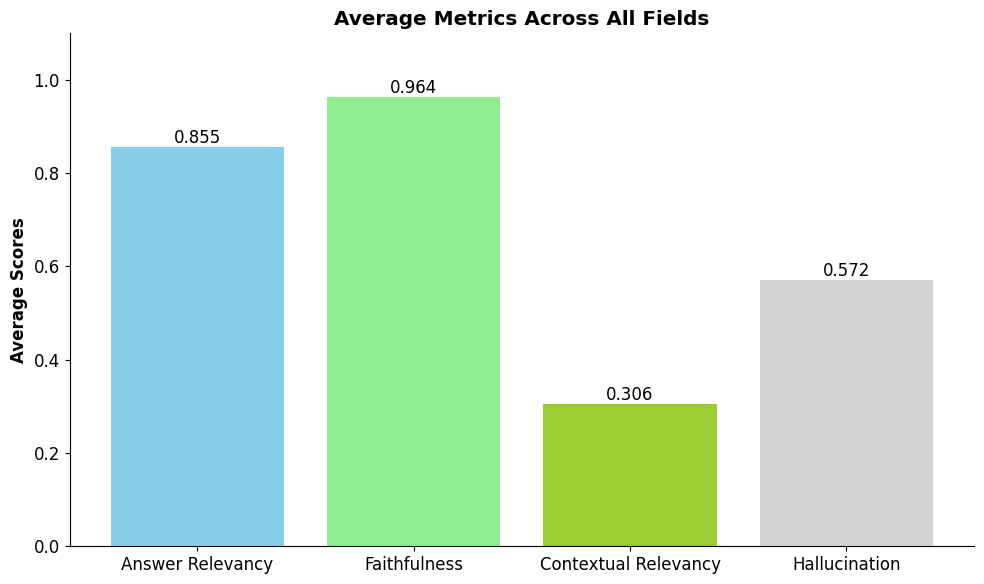

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Increase the default figure size
plt.rcParams['figure.figsize'] = [10, 6]

# Increase the font size for better readability
plt.rcParams['font.size'] = 12

# Calculate averages across all fields
avg_answer_relevancy = np.mean(answer_relevancy_metrics)
avg_faithfulness = np.mean(faithfulness_metrics)
avg_contextual_relevancy = np.mean(contextual_relevancy_metrics)
avg_hallucination = np.mean(hallucination_metrics)

# Prepare data for plotting
labels = ['Answer Relevancy', 'Faithfulness', 'Contextual Relevancy', 'Hallucination']
averages = [avg_answer_relevancy, avg_faithfulness, avg_contextual_relevancy, avg_hallucination]
colors = ['skyblue', 'lightgreen', 'yellowgreen', 'lightgrey']

# Create the bar chart
fig, ax = plt.subplots()
bars = ax.bar(labels, averages, color=colors)

ax.set_ylabel('Average Scores', fontweight='bold')
ax.set_title('Average Metrics Across All Fields', fontweight='bold')
ax.set_ylim(0, 1.1)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom')

# Adjust layout and display
plt.tight_layout()
plt.show()


# RAG Question Dataset

- generate answers question answer pairs from the dataset and see how good the rag can answer them